In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

##Load data

In [3]:
df = pd.read_csv('/content/aggregate_median_jams_Kota Banjar.csv', parse_dates=['time'])
df

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry
0,2022-07-06 02:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,1,2201.0,84.0,29.779999,6,33489989,2022-07-06,1.0,"MULTILINESTRING ((108.470602 -7.350802, 108.47..."
1,2022-07-06 06:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,87.0,10.670000,1,33489990,2022-07-06,3.0,"LINESTRING (108.541986 -7.369257, 108.541931 -..."
2,2022-07-06 07:00:00,32.79,KOTA BANJAR,N15 Siliwangi,2,1637.0,110.0,27.110000,7,33489992,2022-07-06,2.0,"MULTILINESTRING ((108.566017 -7.359884, 108.56..."
3,2022-07-06 07:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,65.5,12.035000,2,33489991,2022-07-06,3.0,"LINESTRING (108.541068 -7.374205, 108.541374 -..."
4,2022-07-06 09:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,2,501.0,63.5,12.705000,2,33489995,2022-07-06,2.0,"LINESTRING (108.541931 -7.369831, 108.541986 -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,2022-09-04 17:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Batulawang,2,3354.0,176.0,25.060000,11,37245088,2022-09-04,2.0,"MULTILINESTRING ((108.54085 -7.382129, 108.540..."
1546,2022-09-04 18:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,1,1845.0,82.0,28.300000,7,37245089,2022-09-04,1.0,"MULTILINESTRING ((108.509759 -7.348402, 108.50..."
1547,2022-09-04 19:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,4,188.0,100.0,5.420000,13,37245090,2022-09-04,4.0,"MULTILINESTRING ((108.486276 -7.348458, 108.48..."
1548,2022-09-04 20:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,1,1887.0,115.0,24.880000,5,37245091,2022-09-04,1.0,"MULTILINESTRING ((108.470602 -7.350802, 108.47..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   time                       1550 non-null   datetime64[ns]
 1   kemendagri_kabupaten_kode  1550 non-null   float64       
 2   kemendagri_kabupaten_nama  1550 non-null   object        
 3   street                     1386 non-null   object        
 4   level                      1550 non-null   int64         
 5   median_length              1550 non-null   float64       
 6   median_delay               1550 non-null   float64       
 7   median_speed_kmh           1550 non-null   float64       
 8   total_records              1550 non-null   int64         
 9   id                         1550 non-null   int64         
 10  date                       1550 non-null   object        
 11  median_level               1550 non-null   float64       
 12  geomet

* Data kemacetan di Kota Banjar terdiri dari 13 kolom dan 1550 baris
* Kolom `street` memiliki null
* Categorical: `kemendagri_kabupaten_kode`, `kemendagri_kabupaten_nama`, `street`, `level`/`median level`, `id`

In [6]:
cats = ['kemendagri_kabupaten_kode', 'kemendagri_kabupaten_nama', 'street', 'level', 'id']
df[cats].nunique()

kemendagri_kabupaten_kode       1
kemendagri_kabupaten_nama       1
street                         31
level                           4
id                           1550
dtype: int64

* Categorical data dengan high- maupun low-cardinality tidak akan digunakan dalam membangun model kemacetan
* Baris yang mengandung null akan di-drop

In [7]:
df = df.dropna()
df.shape

(1386, 13)

## EDA

### Distribusi tingkat kemacetan

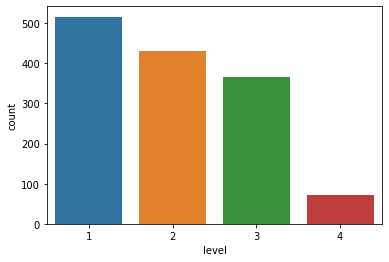

In [21]:
sns.countplot(data=df, x='level');

Tingkat kemacetan direpresentasikan dalam rentang 0--5. Semakin tinggi, kemacetan semakin parah. Klasifikasi ini dilakukan oleh Waze dengan detail sbb:
* 0 = free flow speed -- 80% of free flow speed (lancar)
* 1 = 80% -- 61% of free flow speed
* 2 = 60% -- 41% of free flow speed
* 3 = 40% -- 21% of free flow speed
* 4 = 20 -- 1% of free flow speed
* 5 = blocked road

Berdasarkan visualisasi di atas, mayoritas kemacetan yang terjadi di Kota Banjar antara tanggal 6 Juli 2022 hingga 6 September 2022 tidak terlalu parah (level 1 dan 2).

### Distribusi panjang kemacetan, jeda perjalanan, dan kecepatan kendaraan

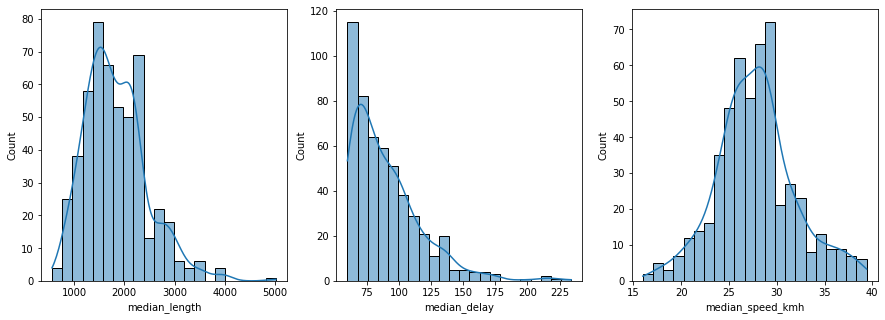

In [51]:
nums = ['median_length', 'median_delay', 'median_speed_kmh']

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 1], kde=True, ax=ax)


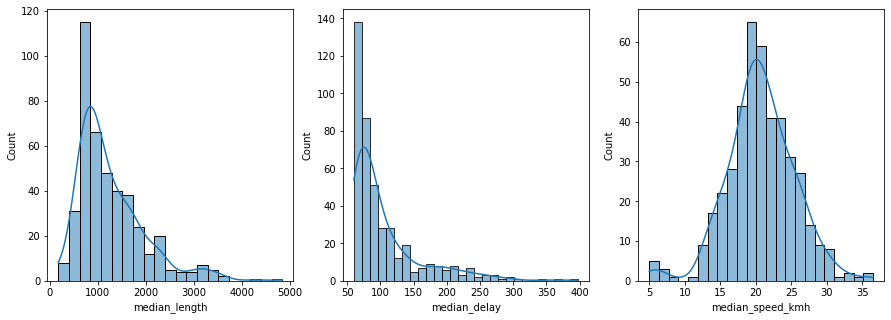

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 2], kde=True, ax=ax)

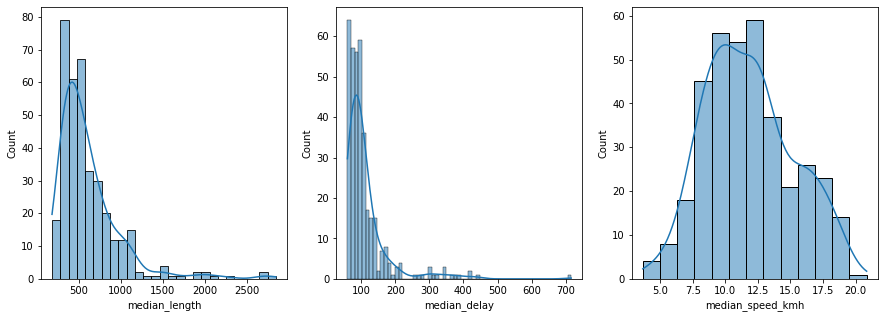

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 3], kde=True, ax=ax)

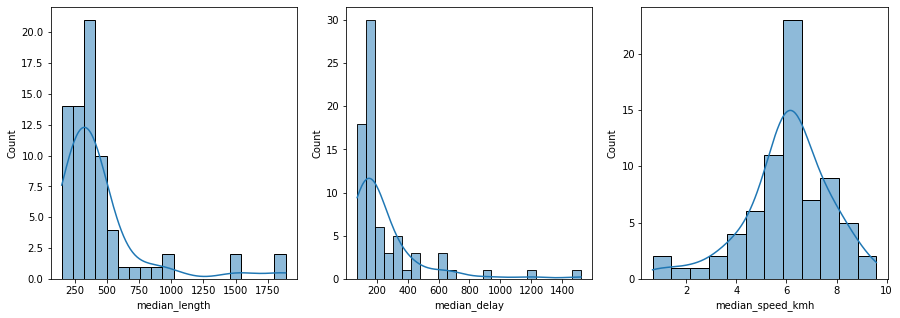

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 4], kde=True, ax=ax)

Berdasarkan visualisasi di atas, panjang kemacetan (`median_length` dalam meter) dan jeda perjalanan akibat kemacetan (`median_delay` dalam detik) untuk tiap tingkat kemacetan masing-masing jarang mencapai 2 km ataupun 250 detik. Kemudian, semakin tinggi tingkat kemacetan, kecepatan kendaraan pun semakin lambat.

Pemodelan akan dilakukan untuk memahami faktor yang paling berkaitan dengan tingkat kemacetan di Kota Banjar berdasarkan lokasi (jalan) dan waktu (hari dan jam).

Untuk membantu hal ini, kolom baru yang memuat hanya informasi hari (`dayofweek`) dan jam (`hour`) dibuat. 

In [8]:
df['dayofweek'] = df['time'].dt.day_name()
df['hour'] = df['time'].dt.time

<ipython-input-8-f85cd1b243b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['time'].dt.day_name()


In [14]:
df.head()

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry,dayofweek,hour
0,2022-07-06 02:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,1,2201.0,84.0,29.779999,6,33489989,2022-07-06,1.0,"MULTILINESTRING ((108.470602 -7.350802, 108.47...",Wednesday,02:00:00
1,2022-07-06 06:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,87.0,10.670000,1,33489990,2022-07-06,3.0,"LINESTRING (108.541986 -7.369257, 108.541931 -...",Wednesday,06:00:00
2,2022-07-06 07:00:00,32.79,KOTA BANJAR,N15 Siliwangi,2,1637.0,110.0,27.110000,7,33489992,2022-07-06,2.0,"MULTILINESTRING ((108.566017 -7.359884, 108.56...",Wednesday,07:00:00
3,2022-07-06 07:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,65.5,12.035000,2,33489991,2022-07-06,3.0,"LINESTRING (108.541068 -7.374205, 108.541374 -...",Wednesday,07:00:00
4,2022-07-06 09:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,2,501.0,63.5,12.705000,2,33489995,2022-07-06,2.0,"LINESTRING (108.541931 -7.369831, 108.541986 -...",Wednesday,09:00:00


## Data Splitting

Karena pemodelan ini dilakukan untuk memahami kemacetan yang terjadi di Kota Banjar pada tanggal 6 Juli 2022 -- 6 September 2022 (diagnostic analytics), splitting hanya dilakukan untuk mendapatkan X dan y.

In [62]:
# Split antara features dan target variable
features = ['street', 'dayofweek', 'hour']
target = 'level'

X = df[features]
y = df[target]

## Iterate

Karena target variable-nya merupakan categorical data, akan dilakukan pemodelan klasifikasi, yakni logistic regression, decision tree, dan random forest (ensemble model dari decision tree). Model dengan akurasi tertinggi dianggap sebagai model terbaik yang dapat menjelaskan faktor yang paling berkaitan dengan kemacetan di Kota Banjar pada waktu yang telah disebutkan.

###Model 1: Logistic regression

In [58]:
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [63]:
# Build model
lr = make_pipeline(OneHotEncoder(),
                   LogisticRegression(max_iter=1000))
# Fit model to training data
lr.fit(X, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [82]:
print("Accuracy:", round(lr.score(X,y), 3))

Accuracy: 0.579


In [67]:
features_ = lr.named_steps['onehotencoder'].get_feature_names_out()
importances = lr.named_steps['logisticregression'].coef_[0]

In [68]:
odds_ratios = pd.Series(np.exp(importances), index=features_).sort_values()
odds_ratios.head()

street_N13 Letjen Soewarto         0.122526
street_Mayjen Didi Kartasasmita    0.213108
street_N13 Brigjen M Isa           0.327831
street_N13 Jalan BKR               0.361459
street_Jalan BKR                   0.362240
dtype: float64

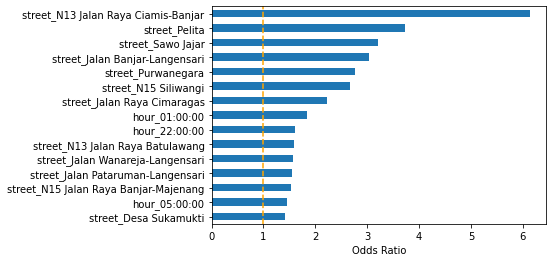

In [69]:
# Horizontal bar chart, 15 largest coefficients
odds_ratios[-15:].plot(kind='barh') #tail
plt.xlabel('Odds Ratio')
plt.axvline(1.0, color='orange', linestyle='--')

##Model 2: Decision tree

In [71]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [73]:
dtc = make_pipeline(OrdinalEncoder(),
                    DecisionTreeClassifier(max_depth=5, random_state=42))
dtc.fit(X, y)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [80]:
print("Accuracy:", round(dtc.score(X,y), 3))

Accuracy: 0.563


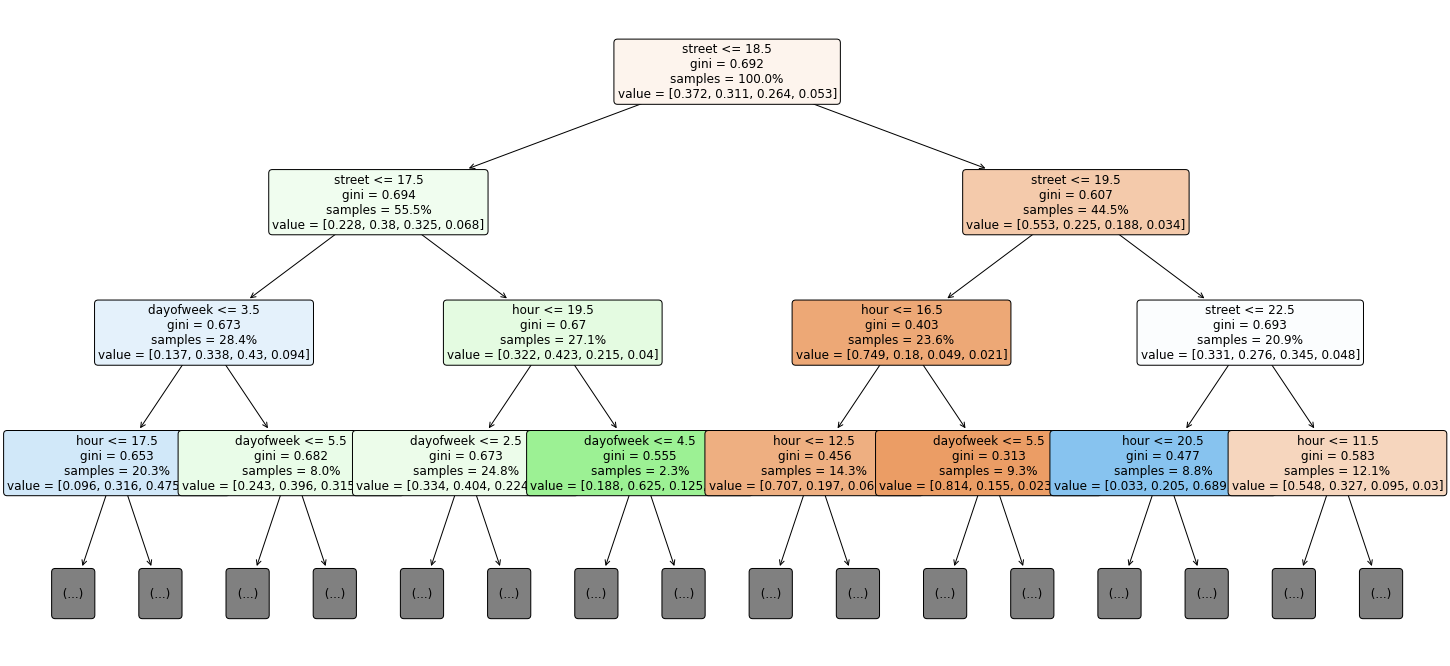

In [75]:

fig, ax = plt.subplots(figsize=(25, 12))

plot_tree(
    decision_tree= dtc.named_steps['decisiontreeclassifier'],
    feature_names= X.columns,
    filled=True,  
    rounded=True,  
    proportion=True,  
    max_depth=3,  
    fontsize=12, 
    ax=ax, 
);

##Model 3: Random forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rfc = make_pipeline(OrdinalEncoder(),
                    RandomForestClassifier(max_depth=10, n_estimators=25, random_state=42))
rfc.fit(X, y)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=25,
                                        random_state=42))])

In [81]:
print("Accuracy:", round(rfc.score(X,y), 3))

Accuracy: 0.702


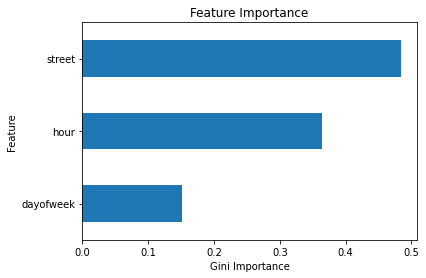

In [79]:
# Get feature names from training data
features_ = X.columns
# Extract importances from model
importances = rfc.named_steps['randomforestclassifier'].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features_).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

##Takeaways

Berdasarkan iterasi yang telah dilakukan, pemodelan dengan random forest classifier (dengan max_depth = 10 dan n_estimators = 25) memiliki akurasi tertinggi dibandingkan yang lainnya. Dari model tersebut, diketahui bahwa lokasi (jalan) adalah faktor yang paling menentukan tingkat kemacetan di Kota Banjar, disusul oleh jam. Sementara itu, hari tidak memiliki bobot yang tinggi (tidak ada kecenderungan kuat antara hari dan tingkat kemacetan tertentu).

Hal ini juga dapat diamati pada model logistic regression maupun decision tree, meski keduanya memiliki akurasi yang relatif rendah. 